# Data Gathering

In [2]:
import geopandas as gp
import os
import numpy as np
from laspy.file import File
from pandas import DataFrame
from shapely.geometry import Point

## Data sources

In [7]:
# Find SRC codes here: https://spatialreference.org/
# SRC code for lidar found here: https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html#/

url_lidar = 'https://lidar.jinha.org/download.php?cname=marion&clon=-86.13305839196093&clat=39.779844384833936&years=2011,2016'
url_vacant_and_abandoned_dataset = 'https://data.indy.gov/datasets/abandoned-and-vacant-housing?geometry=-86.313%2C39.748%2C-85.983%2C39.794'

## Load geo-data on abandoned and vacant buildings

In [8]:
# Abandoned building data is stored here
base_path = './training_data/abandoned_and_vacant/'

# Abandoned building shapefile
gdf_abandoned = gp.read_file(base_path + 'Abandoned_And_Vacant_Housing.shp', crs='EPSG:4326')

print(gdf_abandoned.shape)
gdf_abandoned.head()

(7216, 15)


,OBJECTID,PARCEL_I,STNUMBER,PRE_DIR,STREET_NAM,SUFFIX,SUF_DIR,FULL_STNAM,CITY,ZIPCODE,ADDRESS,STATUS,SHAPEAREA,SHAPELEN,geometry
0,345944,1029867,2365,None,ADAMS,ST,None,ADAMS ST,INDIANAPOLIS,46218,2365 ADAMS ST,Abandoned,12801.863622,480.073502,"POLYGON ((-86.10858 39.80163, -86.10858 39.801..."
1,346056,1010458,2755,N,KEYSTONE,AVE,None,KEYSTONE AVE,INDIANAPOLIS,46218,2755 N KEYSTONE AVE,Abandoned,11133.172761,434.607365,"POLYGON ((-86.12098 39.80677, -86.12146 39.806..."
2,346078,1088338,1929,None,HOUSTON,ST,None,HOUSTON ST,INDIANAPOLIS,46218,1929 HOUSTON ST,Abandoned,5400.130625,350.010293,"POLYGON ((-86.10891 39.79337, -86.10891 39.793..."
3,346248,1024949,40,None,EASTERN,AVE,None,EASTERN AVE,INDIANAPOLIS,46201,40 EASTERN AVE,Abandoned,4999.768822,329.991105,"POLYGON ((-86.11771 39.76975, -86.11816 39.769..."
4,346265,1014955,1031,N,TACOMA,AVE,None,TACOMA AVE,INDIANAPOLIS,46201,1031 N TACOMA AVE,Abandoned,6405.338407,436.020670,"POLYGON ((-86.11886 39.78222, -86.11951 39.782..."


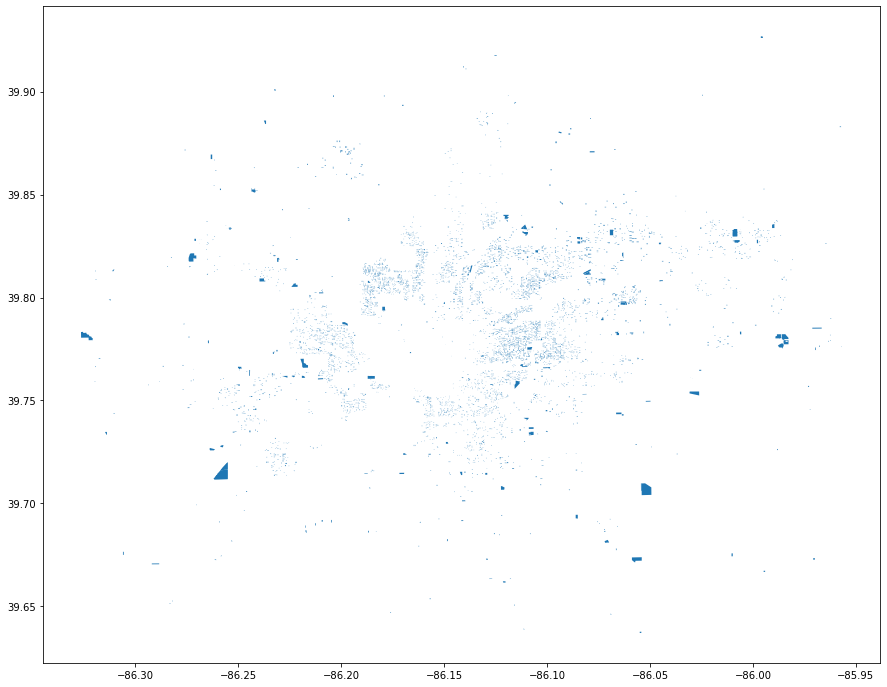

In [9]:
# Map the abandoned properties
gdf_abandoned.plot(figsize=(15,15));

## Load the lidar data for Indianapolis, IN

In [5]:
# Lidar satellite data
las_files = [f for f in os.listdir('./training_data/las_files/')]

las_files

['MC_01951645.las',
 'MC_01951650.las',
 'MC_01951640.las',
 'MC_02051640.las',
 'MC_02051650.las',
 'MC_02051645.las',
 'MC_02001645.las',
 'MC_02001650.las',
 'MC_02001640.las']

In [143]:
def las_to_geodf_development(filename):
    '''Convert an .las file to a Geopandas Geodataframe object.'''

    print('Trying file', filename, '\n')
    
    base_path = './training_data/las_files/'

    #Read LAS file
    try:
        inFile = File(base_path + filename)
        print('inFile accepted.')
    except:
        try:
            inFile2 = File('./training_data/las_files/MC_02051645.las')
            h = inFile2.get_header()
            inFile2.close()
            
            inFile = File(base_path + filename, header=h, mode='w')
            print('inFile accepted with write mode.')
        except:
            print(filename, " failed.")
            return None

    #Import LAS into numpy array
    try:
        lidar_points = np.array((inFile.intensity,
                                 inFile.classification,
                                 inFile.scan_angle)).transpose()
        print('information accepted.')
    except:
        try:
            lidar_points = np.array((inFile.intensity,
                                     inFile.classification,
                                     inFile.scan_angle_rank)).transpose()
            print('information accepted with scan_angle_rank.')
        except:
            print(filename, " failed.")
            inFile.close()
            return None

    #Transform to geopandas GeoDataFrame
    crs = None
    lidar_geodf = gp.GeoDataFrame(lidar_points, geometry = gp.points_from_xy(inFile.x, inFile.y, inFile.z))
    lidar_geodf.rename(columns = {0:'intensity', 1:'classification', 2:'scan_angle'}, inplace=True)
    print('points accepted.')

    print(filename, " successful.\n")
    inFile.close()

    return lidar_geodf

In [165]:
def las_to_geodf(filename, crs):
    '''Convert an .las file to a Geopandas Geodataframe object.'''

    print('Trying file', filename, '\n')
    
    base_path = './training_data/las_files/'

    #Read LAS file
    try:
        inFile = File(base_path + filename)
        print('inFile accepted.')
    except:
        print(filename, " failed.")
        return None

    #Import LAS into numpy array
    lidar_points = np.array((inFile.intensity,
                             inFile.classification,
                             inFile.scan_angle)).transpose()
    print('information accepted.')

    #Transform to geopandas GeoDataFrame
    lidar_geodf = gp.GeoDataFrame(lidar_points, geometry = gp.points_from_xy(inFile.x, inFile.y, inFile.z), crs=crs)
    lidar_geodf.rename(columns = {0:'intensity', 1:'classification', 2:'scan_angle'}, inplace=True)
    print('points accepted.')

    print(filename, " successful.\n")
    inFile.close()

    return lidar_geodf

In [114]:
def merge_geodfs(geodfs):
  result_gdf = geodfs[0]
  for gdf in geodfs[1:]:
    result_gdf = result_gdf.append(gdf).reset_index(drop=True)
  return result_gdf

In [144]:
inFile = File('./training_data/las_files/MC_02051645.las')

In [167]:
crs = 'ESRI:102673'
test = las_to_geodf(las_files[0], crs)

Trying file MC_01951645.las 

inFile accepted.
information accepted.
points accepted.
MC_01951645.las  successful.



In [175]:
test.head()

,intensity,classification,scan_angle,geometry
0,9216,1,-2167,POINT Z (197999.940 1649996.560 746.200)
1,11264,1,-2167,POINT Z (197996.020 1649999.590 746.450)
2,7424,1,-2167,POINT Z (197996.280 1649996.160 746.240)
3,8704,2,-2167,POINT Z (197996.550 1649992.720 746.150)
4,3584,1,-2167,POINT Z (197997.690 1649997.330 781.170)


In [184]:
crs = 'EPSG:102673'
test.crs = crs

In [185]:
test.crs

'EPSG:102673'

In [187]:
new_crs = "EPSG:4326"
test.to_crs(crs=new_crs)

RuntimeError: b'no arguments in initialization list'

In [141]:
# Runtime: 27 minutes

# Convert all las files to geodataframes
lidar_geodfs = [las_to_geodf(filename) for filename in las_files]

Trying file MC_01951645.las 

inFile accepted.
information accepted.
points accepted.
MC_01951645.las  successful.

Trying file MC_01951650.las 

inFile accepted.
information accepted.
points accepted.
MC_01951650.las  successful.

Trying file MC_01951640.las 

inFile accepted.
information accepted.
points accepted.
MC_01951640.las  successful.

Trying file MC_02051640.las 

MC_02051640.las  failed.


UnboundLocalError: local variable 'inFile' referenced before assignment

Failed:  
MC_02051640.las  
MC_02001645.las  
MC_02001640.las

In [14]:
# Runtime: 16 minutes

# Create a single geodataframe
lidar_geodf = merge_geodfs(lidar_geodfs)

In [15]:
lidar_geodf

,x,y,z,intensity,classification,scan_angle,geometry
0,197999.94,1649996.56,746.20,9216.0,1.0,-2167.0,POINT Z (197999.940 1649996.560 746.200)
1,197996.02,1649999.59,746.45,11264.0,1.0,-2167.0,POINT Z (197996.020 1649999.590 746.450)
2,197996.28,1649996.16,746.24,7424.0,1.0,-2167.0,POINT Z (197996.280 1649996.160 746.240)
3,197996.55,1649992.72,746.15,8704.0,2.0,-2167.0,POINT Z (197996.550 1649992.720 746.150)
4,197997.69,1649997.33,781.17,3584.0,1.0,-2167.0,POINT Z (197997.690 1649997.330 781.170)
...,...,...,...,...,...,...,...
10411270,204000.18,1650006.02,765.63,13824.0,1.0,3000.0,POINT Z (204000.180 1650006.020 765.630)
10411271,204000.03,1650000.53,777.74,1280.0,1.0,3000.0,POINT Z (204000.030 1650000.530 777.740)
10411272,204000.12,1650004.54,765.58,12288.0,1.0,3000.0,POINT Z (204000.120 1650004.540 765.580)
10411273,204000.07,1650003.08,765.45,14336.0,2.0,3000.0,POINT Z (204000.070 1650003.080 765.450)


Resulting dataframe is:  
64464045 rows × 7 columns

In [17]:
lidar_small = lidar_geodf.loc[:, ['intensity', 'geometry']].copy()

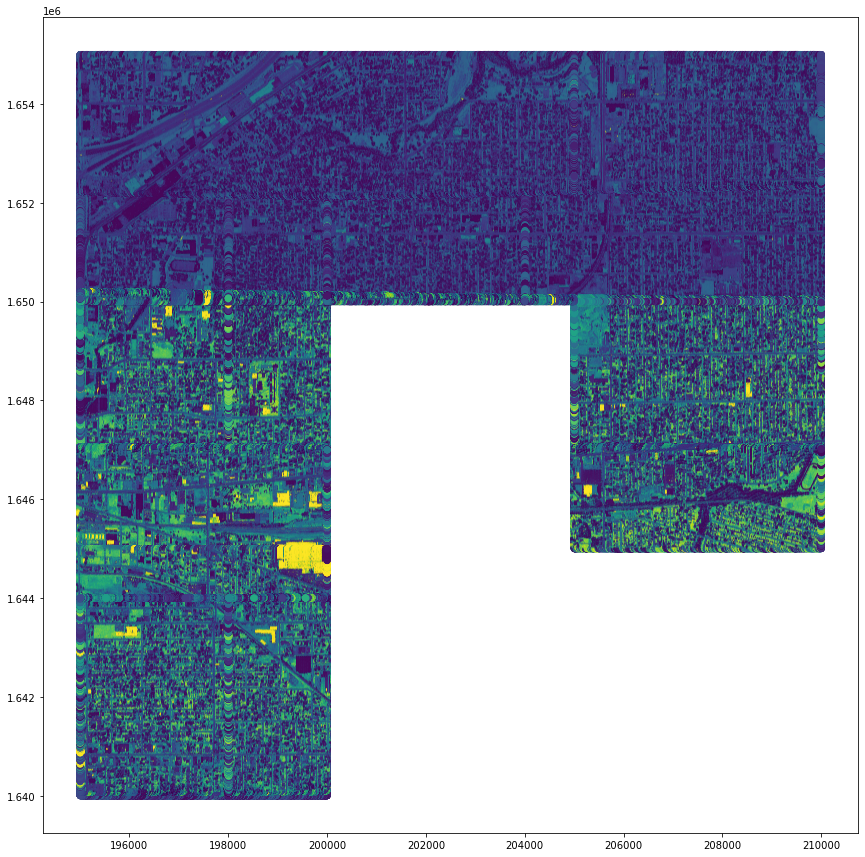

In [18]:
# Duration: Over 2.5 hours

lidar_small.plot('intensity', figsize=(15,15));

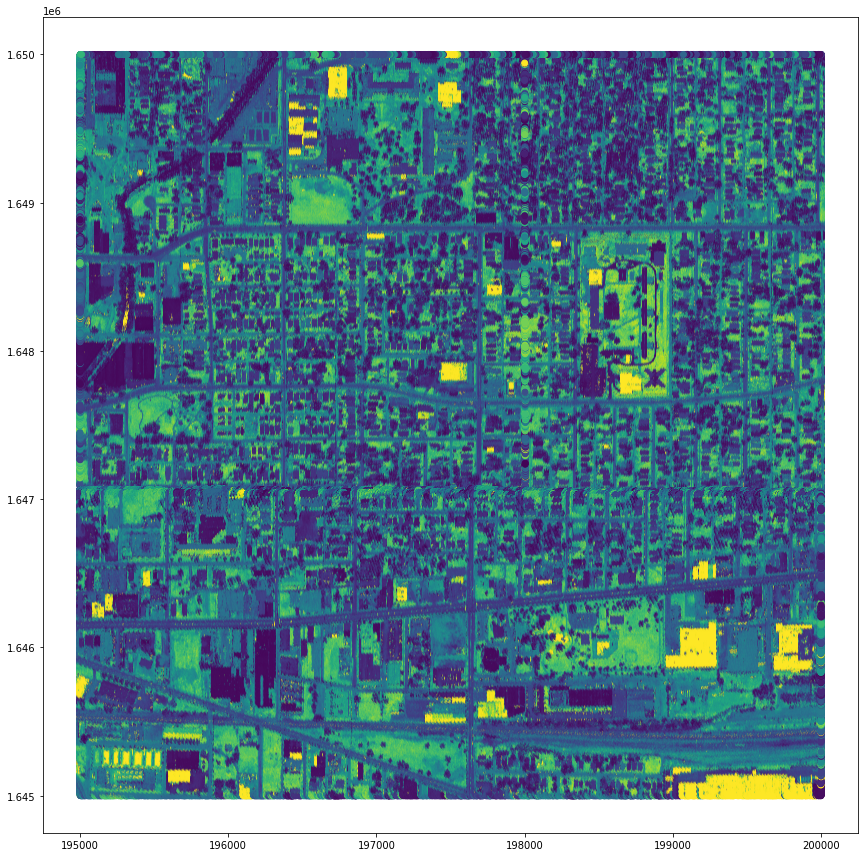

In [14]:
lidar_geodf.plot('intensity', figsize=(15,15));